In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Loading

In [3]:
!git clone https://github.com/ayulockin/synthetic_datasets
%cd synthetic_datasets/MNIST/
%mkdir images

!unzip -q MNIST_Converted_Training.zip -d images/
!unzip -q MNIST_Converted_Testing.zip -d images/

Cloning into 'synthetic_datasets'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 42 (delta 1), reused 1 (delta 1), pack-reused 39
Receiving objects: 100% (42/42), 42.06 MiB | 28.26 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/kaggle/working/synthetic_datasets/MNIST


In [4]:
%cd ../..

/kaggle/working


In [5]:
S='synthetic_datasets'
M='MNIST'
I='images'
t='MNIST_Converted_Training'
train=pd.read_csv(os.path.join(S,M,'training_data.csv'),header=None)
columns=['path','class','xmin','ymin','xmax','ymax']
train.columns=columns
train['path']=train['path'].apply(lambda s:os.path.join(S,M,I,t,s))

t='MNIST_Converted_Testing'
test=pd.read_csv(os.path.join(S,M,'test_data.csv'),header=None)
columns=['path','class','xmin','ymin','xmax','ymax']
test.columns=columns
test['path']=test['path'].apply(lambda s:os.path.join(S,M,I,t,s))
test

,path,class,xmin,ymin,xmax,ymax
0,synthetic_datasets/MNIST/images/MNIST_Converte...,2,0.20,0.45,0.48,0.73
1,synthetic_datasets/MNIST/images/MNIST_Converte...,0,0.02,0.03,0.30,0.31
2,synthetic_datasets/MNIST/images/MNIST_Converte...,4,0.55,0.39,0.83,0.67
3,synthetic_datasets/MNIST/images/MNIST_Converte...,8,0.38,0.42,0.66,0.70
4,synthetic_datasets/MNIST/images/MNIST_Converte...,7,0.69,0.17,0.97,0.45
...,...,...,...,...,...,...
9995,synthetic_datasets/MNIST/images/MNIST_Converte...,5,0.46,0.34,0.74,0.62
9996,synthetic_datasets/MNIST/images/MNIST_Converte...,9,0.54,0.25,0.82,0.53
9997,synthetic_datasets/MNIST/images/MNIST_Converte...,8,0.50,0.32,0.78,0.60
9998,synthetic_datasets/MNIST/images/MNIST_Converte...,0,0.62,0.61,0.90,0.89


In [6]:
print(len(train))
print(len(test))

60000
10000


In [7]:
train=train[:30000]

# Data Preprocessing

In [8]:
def load_img(image_path):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_png(image,channels=1)
  image=tf.image.grayscale_to_rgb(image)
  image=image.numpy().astype(np.uint8)
  #plt.imshow(image)
  #print(image.shape)
  return image

In [9]:
import matplotlib.patches as patches
def bounding_box(image_data):
    image = load_img(image_data[0])
    fig, ax = plt.subplots()
    ax.imshow(image)
    x1, y1, x2, y2 =[int(v*100) for v in image_data[2:]]
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    print("Bounding box")
    plt.show()

Bounding box


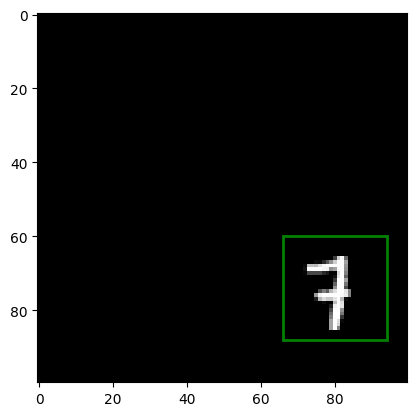

In [10]:
bounding_box(train.iloc[7,:])
#train.iloc[0,5]

In [11]:
val,test=test[:5000],test[5000:]
len(val),len(test)

(5000, 5000)

In [12]:
box_columns=['xmin','ymin','xmax','ymax']

boxes_train=train[box_columns].to_numpy()
boxes_val=val[box_columns].to_numpy()
boxes_test=test[box_columns].to_numpy()

class_train=train['class'].to_numpy()
class_val=val['class'].to_numpy()
class_test=test['class'].to_numpy()

In [13]:
np.unique(class_val).size

10

In [14]:
print("train : ",len(class_train))
print("test : ",len(class_test))
print("val : ",len(class_val))

train :  30000
test :  5000
val :  5000


In [15]:
path_train=train['path']
path_val=val['path']
path_test=test['path']

In [16]:
#converting path to tensors
import cv2

In [17]:
train_images=np.array([load_img(path) for path in path_train])


In [18]:
train_images=tf.convert_to_tensor(train_images, dtype=tf.float32)

In [19]:
val_images = np.array([load_img(path) for path in path_val])
val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)

In [20]:
test_images = np.array([load_img(path) for path in path_test])
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

In [21]:
print(train_images.shape,test_images.shape,val_images.shape,)

(30000, 100, 100, 3) (5000, 100, 100, 3) (5000, 100, 100, 3)


# Classifier

In [22]:
#feature scaling
train_images=train_images/255.
val_images=val_images/255.
train_images[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [23]:
#encoding
class_train_onehot = np.zeros((len(class_train), 10))
class_train_onehot[np.arange(len(class_train)), class_train] = 1

# One-hot encode class_val
class_val_onehot = np.zeros((len(class_val), 10))
class_val_onehot[np.arange(len(class_val)), class_val] = 1

# One-hot encode class_test
class_test_onehot = np.zeros((len(class_test), 10))
class_test_onehot[np.arange(len(class_test)), class_test] = 1


# Regressor

In [24]:
tf.random.set_seed(42)
regressor=tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(100,100,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2,padding="valid"),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(100,100,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2,padding="valid"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

regressor.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae']
)

regressor_history = regressor.fit(train_images, boxes_train,
                                  epochs=50,
                                  batch_size=32,
                                  validation_data=(val_images,boxes_val))


Epoch 1/50
938/938 [==============================] - 20s 12ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 2/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 3/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0087 - val_mae: 0.0087
Epoch 4/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0091 - mae: 0.0091 - val_loss: 0.0075 - val_mae: 0.0075
Epoch 5/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0080 - mae: 0.0080 - val_loss: 0.0084 - val_mae: 0.0084
Epoch 6/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0075 - mae: 0.0075 - val_loss: 0.0072 - val_mae: 0.0072
Epoch 7/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0075 - mae: 0.0075 - val_loss: 0.0067 - val_mae: 0.0067
Epoch 8/50
938/938 [==============================] - 9s 10ms/step -

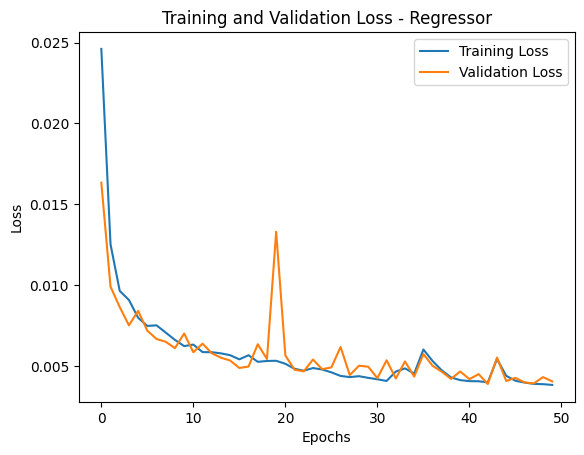

In [25]:
import matplotlib.pyplot as plt

history = regressor_history.history

plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss - Regressor')
plt.show()


In [26]:
x=tf.expand_dims(test_images[2],axis=0)
x=x/255.
box_predicted=regressor.predict(x)
box_actual=boxes_test[2]
print("predicted : ",box_predicted)
print("actual: ",box_actual)
print("Error : ",box_predicted-[box_actual])

1/1 [==============================] - 0s 187ms/step
predicted :  [[0.14565784 0.484095   0.428591   0.7658748 ]]
actual:  [0.15 0.49 0.43 0.77]
Error :  [[-0.00434216 -0.00590499 -0.00140899 -0.0041252 ]]


In [27]:
tf.random.set_seed(42)
classifier=tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(100,100,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2,padding="valid"),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,padding="valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(10,activation="softmax")
])

classifier.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

clf_history=classifier.fit(
    x=train_images,
    y=class_train_onehot,
    epochs=10,
    validation_data=(val_images,class_val_onehot),
  )

Epoch 1/10
938/938 [==============================] - 11s 10ms/step - loss: 1.9228 - accuracy: 0.2843 - val_loss: 1.2715 - val_accuracy: 0.5126
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 1.0654 - accuracy: 0.5962 - val_loss: 0.9103 - val_accuracy: 0.6496
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.8078 - accuracy: 0.6988 - val_loss: 0.8093 - val_accuracy: 0.6908
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.6535 - accuracy: 0.7621 - val_loss: 0.7351 - val_accuracy: 0.7336
Epoch 5/10
938/938 [==============================] - 10s 10ms/step - loss: 0.5484 - accuracy: 0.8060 - val_loss: 0.7435 - val_accuracy: 0.7404
Epoch 6/10
938/938 [==============================] - 10s 11ms/step - loss: 0.4563 - accuracy: 0.8395 - val_loss: 0.6988 - val_accuracy: 0.7644
Epoch 7/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3708 - accuracy: 0.8741 - val_loss: 0.6794 - val_accuracy: 0.774

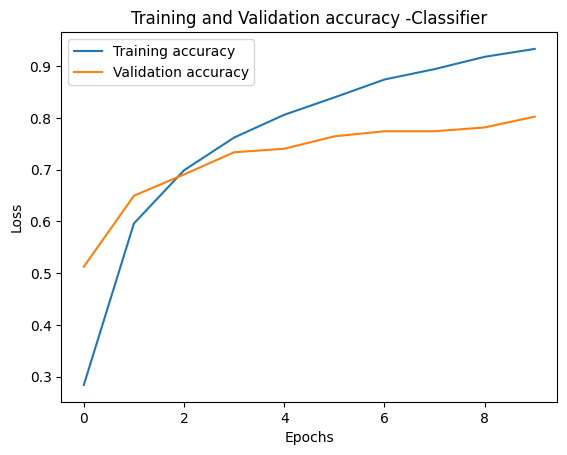

In [28]:
history = clf_history.history

plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation accuracy -Classifier')
plt.show()


In [29]:
x=tf.expand_dims(test_images[2],axis=0)
x=x/255.
class_predicted=classifier.predict(x)
class_actual=class_test[2]
print("predicted : ",np.argmax(class_predicted[0]))
print("actual: ",class_actual)

1/1 [==============================] - 0s 69ms/step
predicted :  5
actual:  5


# Application

Bounding box


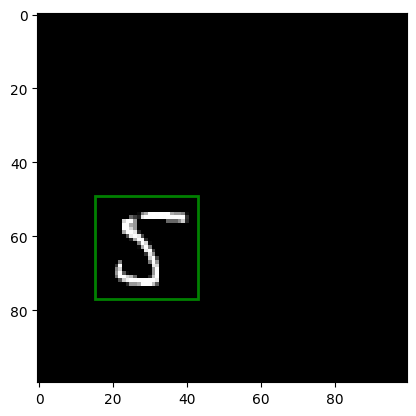

In [30]:
bounding_box(test.iloc[2,:])

In [31]:
def detect(img_no):
  #print(image_path)

  #image=load_img(image_path)
  x=tf.expand_dims(test_images[img_no],axis=0)
  x=x/255.
  class_predicted=classifier.predict(x)
  print("predicted : ",np.argmax(class_predicted[0]))
  print("confidence : ",max(class_predicted[0]))
  conf=max(class_predicted[0])
  if(conf>0.5):
    box_predicted=regressor.predict(x)
    print("boxes predicted : ",box_predicted[0])
    xmin,ymin,xmax,ymax=[int(v*100) for v in box_predicted[0]]

    fig, ax = plt.subplots()
    ax.imshow(test_images[img_no])
    width = xmax-xmin
    height = ymax-ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    print("Result")
    plt.show()


1/1 [==============================] - 0s 20ms/step
predicted :  2
confidence :  0.98643374
1/1 [==============================] - 0s 40ms/step
boxes predicted :  [0.37832487 0.5053665  0.66115046 0.7875691 ]
Result


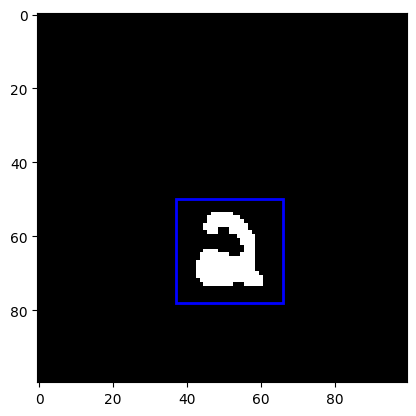

In [32]:
import random
detect(random.randint(0,5000))

In [33]:
def detect_path(image_path):
  print(image_path)
  image=load_img(image_path)
  image=np.array(load_img(image_path))
  image=tf.convert_to_tensor(image, dtype=tf.float32)
  x=tf.expand_dims(image,axis=0)
  x=x/255.
  class_predicted=classifier.predict(x)
  print("predicted : ",np.argmax(class_predicted[0]))
  print("confidence : ",max(class_predicted[0]))
  conf=max(class_predicted[0])
  if(conf>0.5):
    box_predicted=regressor.predict(x)
    print("boxes predicted : ",box_predicted[0])
    xmin,ymin,xmax,ymax=[int(v*100) for v in box_predicted[0]]

    fig, ax = plt.subplots()
    ax.imshow(image)
    width = xmax-xmin
    height = ymax-ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    print("Result")
    plt.show()


synthetic_datasets/MNIST/images/MNIST_Converted_Testing/converted_testing7518.png
1/1 [==============================] - 0s 20ms/step
predicted :  4
confidence :  0.9999957
1/1 [==============================] - 0s 20ms/step
boxes predicted :  [0.57182086 0.0853809  0.8529324  0.36619872]
Result


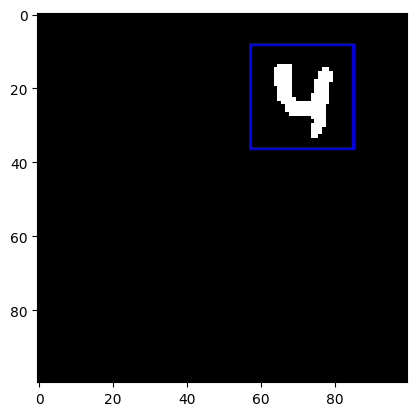

In [34]:
detect_path(test.iloc[random.randint(0,5000),0])